In [117]:
### Python 3.8.10
# major requirements below

!python --version

import pandas
print("pandas", pandas.__version__)

import numpy
print("numpy", numpy.__version__)

import sklearn
print("sklearn", sklearn.__version__)

Python 3.8.10
pandas 1.4.2
numpy 1.22.4
sklearn 1.3.2


In [ ]:


import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

if os.getcwd().replace("algorithm_development", "utils") not in sys.path:
    sys.path.append(os.getcwd().replace("algorithm_development", "utils"))

import utils
import parse_fit

pd.options.display.max_columns = 100

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
strava_export_path = "\\".join(os.getcwd().split("\\")[:-2]) + "\\export_105647830"

In [3]:
activities_df = pd.read_csv(f"{strava_export_path}\\activities.csv")
activities_df["Filename"] = activities_df["Filename"].apply(lambda v: v.split("/")[1].replace(".gz", "")
                                                            if isinstance(v, str) else v)

In [4]:
list_of_fit_files = ["\\".join((strava_export_path + "\\activities", v)) for v in os.listdir(strava_export_path + "\\activities")
                     if ".gpx" not in v and ".gz" not in v]
list_of_gpx_files = ["\\".join((strava_export_path + "\\activities", v)) for v in os.listdir(strava_export_path + "\\activities")
                     if ".gpx" in v]

In [5]:
# SAVE FILES TO AVOID RECOMPUTING EACH TIME
fit_file_laps = pd.read_parquet("{}\\fit_file_laps.parquet".format("\\".join(strava_export_path.split("\\")[:-1] + ["\\data"])))
fit_file_points = pd.read_parquet("{}\\fit_file_points.parquet".format("\\".join(strava_export_path.split("\\")[:-1] + ["\\data"])))

In [13]:
example = utils.slice_parquet_activity(activities_df, fit_file_points, "Granfondo BGY")
example.head(2)

,FileName,lap,distance,speed,enhanced_speed,heart_rate,power,cadence,grade,slope,current_slope,altitude,enhanced_altitude,filtered_altitude,latitude,position_lat,longitude,position_long,temperature,time_from_course,timestamp,Activity Name,Athlete Weight,Bike Weight,Weighted Average Power
0,12109821153.fit,1,0.00,4.124,4.124,103.0,NaN,35.0,NaN,NaN,NaN,275.4,275.4,NaN,45.710826,545351401,9.677776,115460361,NaN,None,2024-05-05 05:02:41+00:00,Granfondo BGY,NaN,9.8,NaN
1,12109821153.fit,1,20.01,3.284,3.284,109.0,NaN,61.0,NaN,NaN,NaN,275.0,275.0,NaN,45.710653,545349329,9.677843,115461167,NaN,None,2024-05-05 05:02:45+00:00,Granfondo BGY,NaN,9.8,NaN


In [18]:
utils.compute_power(weight=85.5, bike_wgt=8.8, speed=5.524, slope=7.097182)

8.420499165721347

In [22]:
from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

In [20]:
def data_prep(df, weight, bike_wgt, rest_hr, max_hr, split = True, has_real_power = True):
    Xy = df[["altitude", "cadence", "enhanced_speed", "current_slope", "heart_rate", "distance", "power"]].copy()
    # heart_rate w.r.t. rest HR and max HR
    Xy["heart_rate"] = 100 * (Xy['heart_rate']/ (max_hr-rest_hr))
    Xy["heart_rate"] = Xy["heart_rate"].bfill()
    Xy["current_slope"] = Xy["current_slope"].fillna(0)
    Xy.loc[(Xy["cadence"].isnull()) & (Xy["enhanced_speed"] == 0), "cadence"] = 0
    Xy["distance"] = Xy["distance"] / 1000
    Xy["power"] = Xy["power"].fillna(0)
    Xy["power"] = Xy["power"]/weight

    # Xy["athlete_weight"] = 85.5
    # Xy["bike_weight"] = 8.8

    Xy = Xy.dropna(how = "any").reset_index(drop = True)

    Xy["estimated_power"] = Xy.apply(lambda row: utils.compute_power(weight = weight, bike_wgt = bike_wgt,
                                                                     speed = row["enhanced_speed"],
                                                                     slope = row["current_slope"]),
                                    axis = 1)

    X = Xy.drop("power", axis = 1)
    y = Xy["power"]
    
    if split:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True)
        return X_train, X_test, y_train, y_test
    else:
        return X, y

In [23]:
def model_pipeline(X_train, X_test, y_train, y_test, weight, early_stop = False):
    # Uneducated guess
    print("RMSE: {:.2f}".format(mean_squared_error(y_train, X_train["estimated_power"], squared=False)))
    print("MAE: {:.2f} W/kg ({:.2f} W)".format(mean_absolute_error(y_train, X_train["estimated_power"]),
                                               mean_absolute_error(y_train, X_train["estimated_power"]) * weight))

    plt.figure(figsize = (16, 5))
    plt.plot(sorted(pd.concat([y_train, y_test], ignore_index=True))[::-1], label = "REAL POWER")
    plt.plot(sorted(pd.concat([X_train, X_test], ignore_index=True)["estimated_power"])[::-1], label = "PREDICTED")
    plt.title("UNEDUCATED GUESS - Test power curve")
    plt.legend()
    plt.show()

    if early_stop:
        return None

    # Initialize a Decision Tree Classifier

    d3 = DecisionTreeRegressor(random_state = 101, criterion = "absolute_error")
    d3.fit(X_train, y_train)
    print("Tree Train RMSE: {:.4f}\n".format((mean_squared_error(y_train, d3.predict(X_train), squared=True))))

    # Compute impurities to look for an adequate pruning term
    path = d3.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    # Plot the impurity level given ccp_alpha
    plt.plot(ccp_alphas[:-1], impurities[:-1], marker = "o", drawstyle = "steps-post")
    plt.xlabel("effective alpha")
    plt.ylabel("total impurity of leaves")
    plt.title("Total Impurity vs effective alpha for training set")
    plt.show()

    # Tree Pruning (we are overfitting - Accuracy: 100% in training)
    tree_params = {"ccp_alpha":[ccp_alphas[impurities < impty].max()
                                for impty in np.linspace(0.1, np.round(impurities.max()/2, 3),
                                                        num = 5)]}

    tree_grid = GridSearchCV(DecisionTreeRegressor(random_state = 101, criterion = "absolute_error"),
                            tree_params, cv = 3, n_jobs = 6, verbose = 10,
                            return_train_score = True)
    tree_grid.fit(X_train, y_train)

    # Show the results
    print("With ReLU")
    print("RMSE: {:.2f}".format(mean_squared_error(y_test, utils.ReLU(tree_grid.best_estimator_.predict(X_test)), squared=True)))
    print("MAE: {:.2f} W/kg ({:.2f} W)".format(mean_absolute_error(y_test, utils.ReLU(tree_grid.best_estimator_.predict(X_test))),
                                               mean_absolute_error(y_test, utils.ReLU(tree_grid.best_estimator_.predict(X_test))) * weight))
    # print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, ReLU(tree_grid.best_estimator_.predict(X_test)))))
    print()
    print("Without ReLU")
    print("RMSE: {:.2f}".format(mean_squared_error(y_test, tree_grid.best_estimator_.predict(X_test), squared=True)))
    print("MAE: {:.2f} W/kg ({:.2f} W)".format(mean_absolute_error(y_test, tree_grid.best_estimator_.predict(X_test)),
                                               mean_absolute_error(y_test, tree_grid.best_estimator_.predict(X_test)) * weight))
    # print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, tree_grid.best_estimator_.predict(X_test))))

    plt.figure(figsize = (16, 5))
    plt.plot(sorted(y_test)[::-1], label = "REAL POWER", lw = 5)
    plt.plot(sorted(utils.ReLU(tree_grid.best_estimator_.predict(X_test)))[::-1], label = "PREDICTED + RELU", lw = 5)
    plt.plot(sorted(tree_grid.best_estimator_.predict(X_test))[::-1], label = "PREDICTED", alpha = .8, ls = "--")
    plt.title("DECISION TREE - Test power curve")
    plt.legend()
    plt.show()

    return tree_grid.best_estimator_

In [24]:
_, dr = parse_fit.get_dataframes("{}\\16438299806_ACTIVITY.fit".format("\\".join(strava_export_path.split("\\")[:-1] + ["\\data\\DR"])))

RMSE: 1.83
MAE: 1.22 W/kg (103.97 W)


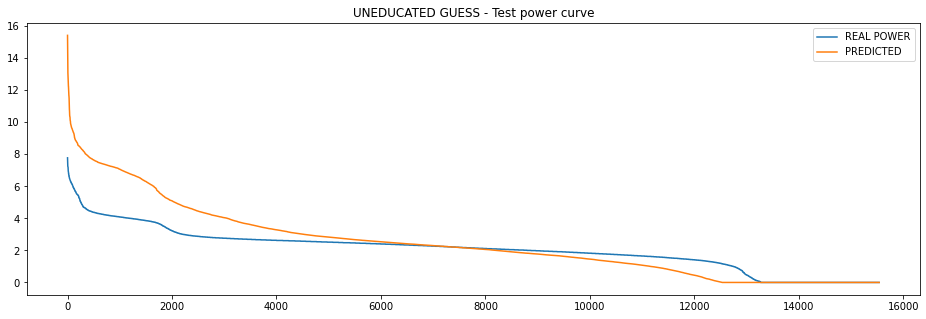

Tree Train RMSE: 0.0000



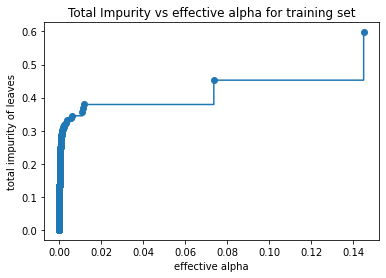

Fitting 3 folds for each of 5 candidates, totalling 15 fits
With ReLU
RMSE: 0.19
MAE: 0.24 W/kg (20.23 W)

Without ReLU
RMSE: 0.19
MAE: 0.24 W/kg (20.23 W)


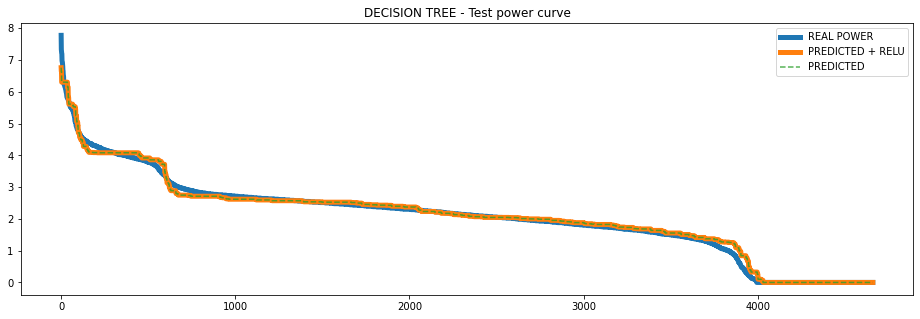

In [26]:
dr_X_train, dr_X_test, dr_y_train, dr_y_test = data_prep(dr, weight = 85.5, bike_wgt = 8.8, rest_hr = 55, max_hr = 195)
model = model_pipeline(dr_X_train, dr_X_test, dr_y_train, dr_y_test, weight = 85.5)

In [27]:
# test on all DR files
for f in os.listdir("\\".join(strava_export_path.split("\\")[:-1] + ["\\data\\DR"])):
    if ".fit" in f:
        _, data = parse_fit.get_dataframes("{}\\{}".format("\\".join(strava_export_path.split("\\")[:-1] + ["\\data\\DR"]), f ))

        X_input, y_input = data_prep(dr, weight = 85.5, bike_wgt = 8.8, rest_hr = 55, max_hr = 195, split = False)

        print("RMSE: {:.2f}".format(mean_squared_error(y_input, model.predict(X_input), squared=True)))
        print("MAE: {:.2f} W/kg ({:.2f} W)".format(mean_absolute_error(y_input, model.predict(X_input)),
                                                mean_absolute_error(y_input, model.predict(X_input)) * 85.5))

RMSE: 0.14
MAE: 0.21 W/kg (17.55 W)
RMSE: 0.14
MAE: 0.20 W/kg (17.53 W)
RMSE: 0.14
MAE: 0.20 W/kg (17.48 W)


In [65]:
# test on some of my FIT files
sample_activities = activities_df[~(activities_df["Activity Name"].str.contains("Zwift")) &
                                  (activities_df["Average Watts"].notna()) &
                                  (activities_df["Average Heart Rate"].notna())]["Activity Name"].sample(50)

deltas_avg_power = []
for a in sample_activities:
    # print(a)
    
    input_data = utils.slice_parquet_activity(activities_df, fit_file_points, a, col_subset=False)
    if len(input_data) > 0:
        X_input, y_input = data_prep(input_data, weight = 67, bike_wgt = 9.8, rest_hr = 57, max_hr = 195, split = False)

        recording_interval = input_data["timestamp"].diff().dropna().min().seconds
        if X_input.isnull().sum().sum() == 0:
            
            prediction = model.predict(X_input)
            # print("\tZwift avg Watts: {:.2f}".format(input_data["Average Watts"].max()))
            # print("\tMODEL avg Watts: {:.2f}".format(67 * prediction.mean()))

            deltas_avg_power += [[a, input_data["Average Watts"].max(), 67 * prediction.mean()]]
            
            # plt.figure(figsize = (16, 5))
            # plt.plot(sorted(prediction, reverse=True), label = "PREDICTED")
            # plt.axvline(60 / recording_interval, color = "grey", alpha = .5, ls = "--")
            # plt.axvline(300 / recording_interval, color = "grey", alpha = .5, ls = "--")
            # plt.axvline(3600 / recording_interval, color = "grey", alpha = .5, ls = "--")
            # #plt.xlim(-20, len(X_input) * 1.1)
            # #plt.xscale("log")
            # plt.legend()
            # plt.show()
    else:
        print(f"{a}\tDidn't work")

Per chiudere l'anno 	Didn't work
Morning Ride	Didn't work
Tra pioggia e vento in FVG🌧	Didn't work
Day 2: Coospo e gambe scarichi	Didn't work
Back in Veneto	Didn't work
Allenamento #1	Didn't work
Chill & a torn wrist 	Didn't work


In [66]:
deltas_avg_power = pd.DataFrame(deltas_avg_power,
                                columns=["Activity Name", "Zwift avg Watts", "MODEL avg Watts"])

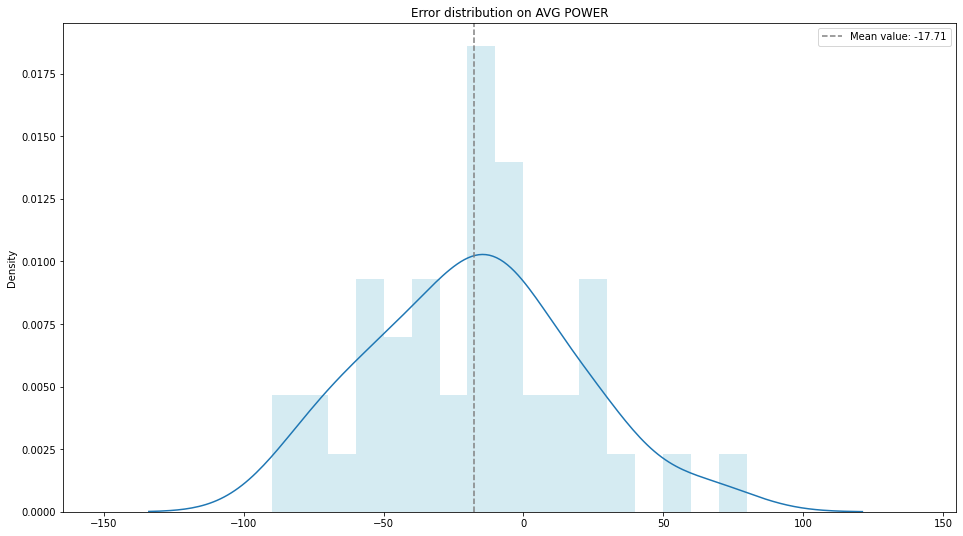

In [69]:
error_n_datasets = deltas_avg_power.iloc[:, 1] - deltas_avg_power.iloc[:, 2]
mean_error_n_datasets = error_n_datasets.mean()

plt.figure(figsize=(16, 9))
sns.kdeplot(error_n_datasets)
plt.hist(error_n_datasets,
         density=True, bins = np.arange(-150, 150, 10),
         alpha = .5, color = "lightblue")
plt.axvline(mean_error_n_datasets, ls = "--", color = "grey",
            label = "Mean value: %.2f" % mean_error_n_datasets)
plt.title("Error distribution on AVG POWER")
plt.legend()
plt.show()

In [80]:
import sklearn
help(sklearn.tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child 

In [94]:
print(model.tree_.threshold.shape,
      model.tree_.feature.shape,
      model.tree_.children_left.shape,
      model.tree_.children_right.shape,
      model.tree_.value.flatten().shape)

output_model_file = pd.DataFrame({"threshold": model.tree_.threshold,
                                  "feature": model.tree_.feature,
                                  "children_left": model.tree_.children_left,
                                  "children_right": model.tree_.children_right,
                                  "value": model.tree_.value.flatten()})

output_model_file.to_csv("./model/model_parameters.csv", index = False)

(543,) (543,) (543,) (543,) (543,)


---
---
---